<h1> Simple Single Layer RNN with Monthly dataset</h1>

In [23]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [24]:
# salmon_data = pd.read_csv(r"/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv")
# salmon_data.head()
# salmon_copy = salmon_data # Create a copy for us to work with 
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [25]:
chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
king_all_copy, king_data= load_data(ismael_path)
print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [26]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [27]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [28]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [29]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [30]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
        
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [31]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
print(y_test.shape)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
print(y_test_not_norm.shape)
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))
print(y_train_not_norm.shape)
print(y_train.shape)

(60, 2)
(54, 1)
(54, 1)
(918, 1)
(918, 1)


In [32]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [33]:
def create_single_layer_rnn_model(x_train, y_train, x_test, y_test, scaler):
    '''
    create single layer rnn model trained on x_train and y_train
    and make predictions on the x_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    #model.add(SimpleRNN(32, return_sequences=True))
    #model.add(SimpleRNN(32, return_sequences=True))
    #model.add(SimpleRNN(1))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # fit the RNN model
    history = model.fit(x_train, y_train, epochs=300, batch_size=64)

    print("predicting")
    # Finalizing predictions
    RNN_train_preds = model.predict(x_train)
    RNN_test_preds = model.predict(x_test)
    
    #Descale
    RNN_train_preds = scaler.inverse_transform(RNN_train_preds)
    y_train = scaler.inverse_transform(y_train)
    RNN_test_preds = scaler.inverse_transform(RNN_test_preds)
    RNN_test_preds = RNN_test_preds.astype(np.int64)
    y_test = scaler.inverse_transform(y_test)

    return model, RNN_train_preds, RNN_test_preds, history, y_train, y_test

In [34]:
model, RNN_train_preds, RNN_test_preds, history_RNN, y_train, y_test = create_single_layer_rnn_model(x_train, y_train, x_test, y_test, scaler)

Epoch 1/300
15/15 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 2/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0099
Epoch 3/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0093
Epoch 4/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0078
Epoch 5/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 6/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0080
Epoch 7/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0075
Epoch 8/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 9/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0091
Epoch 10/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0086
Epoch 11/300
15/15 [==============================] - 0s 3ms/step - loss: 0.0080
Epoch 12/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0065
Epoch 13/300
15/15 [=================

15/15 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 103/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0057
Epoch 104/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 105/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 106/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 107/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 108/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 109/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0061
Epoch 110/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0070
Epoch 111/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 112/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 113/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 114/300
15/15 [=========

15/15 [==============================] - 0s 2ms/step - loss: 0.0033
Epoch 203/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0047
Epoch 204/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 205/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0043
Epoch 206/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 207/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 208/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0046
Epoch 209/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0035
Epoch 210/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0036
Epoch 211/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0045
Epoch 212/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0034
Epoch 213/300
15/15 [==============================] - 0s 2ms/step - loss: 0.0042
Epoch 214/300
15/15 [=========

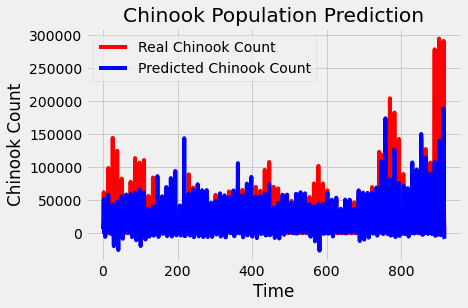

The root mean squared error is 17280.786003235695.
(918, 1)


In [35]:
# plot single_layer_rnn_model
plot_predictions(y_train, RNN_train_preds)
return_rmse(y_train, RNN_train_preds)
print(RNN_train_preds.shape)

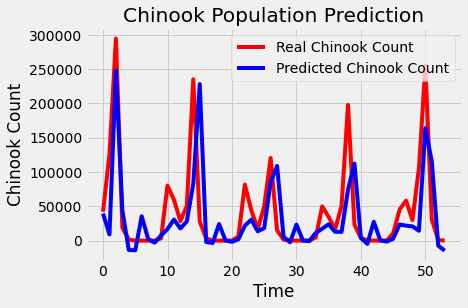

The root mean squared error is 53707.14979473472.


In [36]:
plot_predictions(y_test, RNN_test_preds)
return_rmse(y_test, RNN_test_preds)

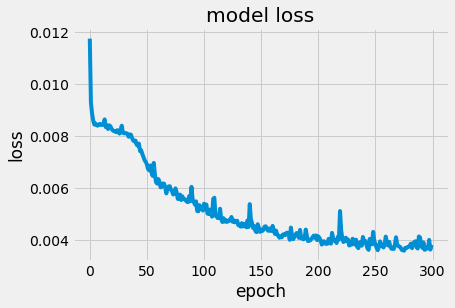

In [37]:
plot_loss(history_RNN)

In [38]:
# global var for baseline
y_test_year = month_to_year(y_test)
len(y_test)
len(y_test_year)

49


4

In [39]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
print(traditional)
y_test_year = y_test_year.astype(np.int64)
print(y_test_year)
# print(GRU_test_year)

49
    Count
0  498710
1  439060
2  294840
3  347600
    Count
0  488943
1  336031
2  381766
3  535809


In [40]:
RNN_test_year = month_to_year(RNN_test_preds)
RNN_test_year

49


,Count
0,431033
1,305159
2,288853
3,376991


In [41]:
# test RMSE with baseline and RNN
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, RNN_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 97676.29085018534.
